In [1]:
import torchaudio
import torch
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def compute_vad_speech_brain(sig, frame_size: 'int (samples) ', frame_shift: 'int (samples)', fs: int = 16000):
    from speechbrain.pretrained import VAD
    VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")

    #sig, fs = torchaudio.load(file_path)
    
    torchaudio.save("ch_0.wav", sig[[0]]/torch.norm(torch.abs(sig[[1]]),2), sample_rate=16000)
    torchaudio.save("ch_1.wav", sig[[1]]/torch.norm(torch.abs(sig[[1]]),2), sample_rate=16000)

    # tgt signal: large_chunk_size = 4, apply_energy_VAD = True, double_check = False, activation_th = 0.9, deactivation_th = 0.8, close_th = 0.100, len_th = 0.050, speech_th=0.9)
    
    boundaries_0 = VAD.get_speech_segments("ch_0.wav", large_chunk_size = 4, apply_energy_VAD = True, double_check = True, activation_th = 0.95, deactivation_th = 0.8, close_th = 0.100, len_th = 0.050, speech_th=0.8)
    boundaries_1 = VAD.get_speech_segments("ch_1.wav", large_chunk_size = 4, apply_energy_VAD = True, double_check = True, activation_th = 0.95, deactivation_th = 0.8, close_th = 0.100, len_th = 0.050, speech_th=0.8)

    upsampled_boundaries_0 = VAD.upsample_boundaries(boundaries_0, "ch_0.wav")
    upsampled_boundaries_1 = VAD.upsample_boundaries(boundaries_1, "ch_1.wav")

    boundary = upsampled_boundaries_0*upsampled_boundaries_1

    sig_vad = []
    sig_size = sig.shape[-1]
    for frame_idx, frm_strt in enumerate(range(0, sig_size-frame_size +1, frame_shift)):
        frame_vad = torch.mean(boundary[0, frm_strt:frm_strt + frame_size])
        frame_dec = 1 if frame_vad > 0.95 else 0
        sig_vad.append(frame_dec)

    return torch.tensor(np.array(sig_vad)), boundary

In [3]:
import sys
sys.path.append('/u/battula12/my_pkgs/zff_vad/')

In [73]:
snr =  -5
t60 =  0.2
src_mic_dist = 1.0
noi_mic_dist = 1.0
scenario = "source_moving"
model_train = "moving"
idx=0
pp_str = f'../signals/{scenario}/{model_train}_model/from_dataset_circular_motion_snr_{snr}_t60_{t60}_src_mic_dist_{src_mic_dist}_noi_mic_dist_{noi_mic_dist}/'
app_str = f'{idx}'

sig, fs = torchaudio.load(f'{pp_str}tgt_{app_str}.wav')

est_sig, fs = torchaudio.load(f'{pp_str}est_{app_str}.wav')

In [4]:
from zff import utils
from zff.zff import zff_vad

# Read audio at native sampling rate
sr, audio = utils.load_audio('/scratch/bbje/battula12/Databases/wsj/tr_05_clean/20l/20lc0102.wav')#f'{pp_str}tgt_{app_str}.wav')

# Get segments
boundary = zff_vad(audio, sr)

# Smooth
boundary = utils.smooth_decision(boundary, sr)

# Convert from sample to time domain
segments = utils.sample2time(audio, sr, boundary)

# Save as .csv file
#utils.save_segments("segments", "audio", segments)

In [19]:
# Read audio at native sampling rate
#sr, audio = utils.load_audio(f'{pp_str}tgt_{app_str}.wav')
from speechbrain.pretrained import VAD
VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")
sph_boundaries_0 = VAD.get_speech_segments('/scratch/bbje/battula12/Databases/wsj/tr_05_clean/20l/20lc0102.wav', apply_energy_VAD = True, double_check = True, activation_th = 0.93, deactivation_th = 0.8, close_th = 0.100, len_th = 0.050, speech_th=0.8)
upsampled_boundaries_0 = VAD.upsample_boundaries(sph_boundaries_0, '/scratch/bbje/battula12/Databases/wsj/tr_05_clean/20l/20lc0102.wav')

In [14]:
sig,fs = torchaudio.load('/scratch/bbje/battula12/Databases/wsj/tr_05_clean/20l/20lc0102.wav')

In [18]:
upsampled_boundaries_0.shape, sig.shape

(torch.Size([1, 169920]), torch.Size([1, 169920]))

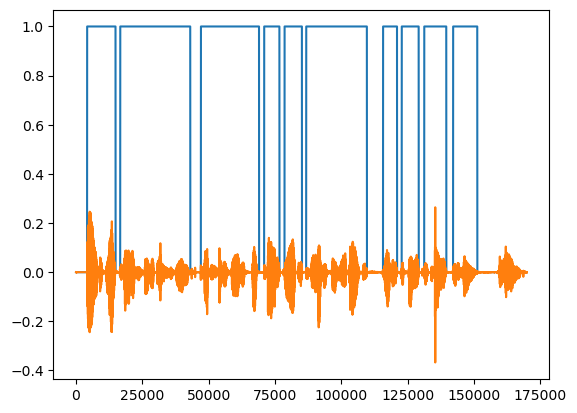

In [20]:
plt.plot(upsampled_boundaries_0[0])
plt.plot(sig[0])

In [88]:
sr, audio.shape, boundary.shape

(16000, (169920,), (320000,))

In [85]:
audio.shape, sig.shape

((169920,), torch.Size([2, 63999]))

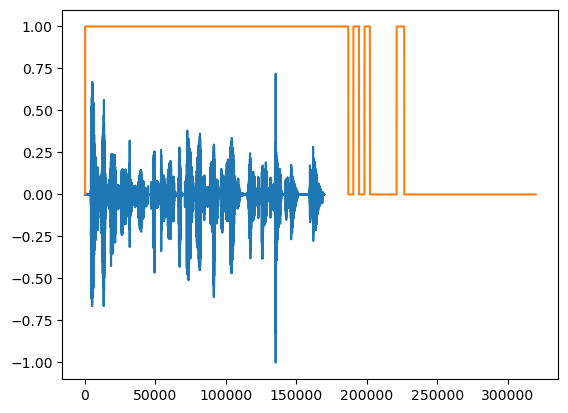

In [5]:
plt.plot(audio)
plt.plot(boundary)

In [60]:
nfft=320
sig_vad, boundary = compute_vad_speech_brain(sig, nfft , nfft//2) #boundary

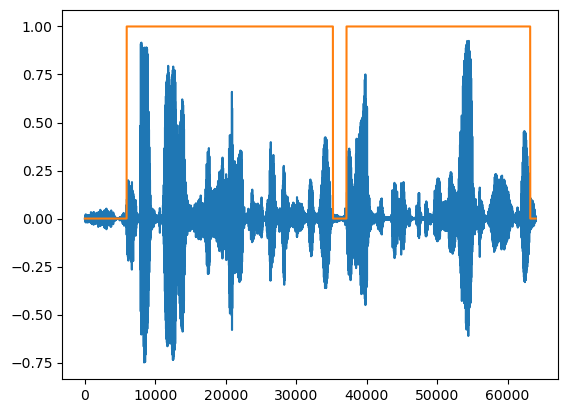

In [61]:
plt.plot(sig[0])
plt.plot(boundary[0])

In [62]:
est_sig_vad, est_boundary = compute_vad_speech_brain(est_sig, nfft , nfft//2) #boundary

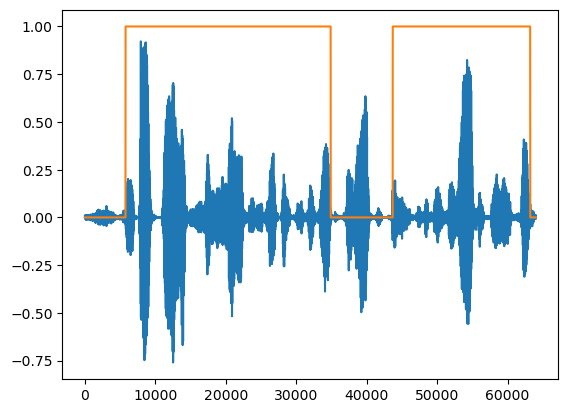

In [63]:
plt.plot(est_sig[0])
plt.plot(est_boundary[0])